In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, recall_score, precision_score, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

2024-01-12 21:55:59.111426: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 21:55:59.422379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 21:55:59.422462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 21:55:59.452738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 21:55:59.539524: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 21:55:59.542279: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
BASE_PATH = 'data/BRCA/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [3]:
from sklearn.model_selection import KFold

In [5]:
X = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
y = np.array([1,2,3,4,5])

In [6]:
kf = KFold(n_splits=3)
kf.get_n_splits(X)

3

In [7]:
print(kf)

KFold(n_splits=3, random_state=None, shuffle=False)


In [8]:
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 3 4] TEST: [0 1]
TRAIN: [0 1 4] TEST: [2 3]
TRAIN: [0 1 2 3] TEST: [4]


In [9]:
BASE_PATH = 'data/BRCA/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [10]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(875, 1002) (875, 1002) (875, 505)


In [12]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']
combined_df['Split'] = methy_df['Split']
print(mrna_df_wol.shape, mrna_df_wos.shape)

(875, 504) (875, 503)


In [13]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df.values, test_df.values, y_train.values, y_test.values

In [14]:
mirna_train, mirna_test, mirna_y,mirna_y_test = get_train_test(mirna_df)
methy_train, methy_test, methy_y,methy_y_test = get_train_test(methy_df)
mrna_train, mrna_test, mrna_y,mrna_y_test = get_train_test(mrna_df)

In [20]:
def scale_dataset(train, test):
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [21]:
mirna_train, mirna_test = scale_dataset(mirna_train, mirna_test)
methy_train, methy_test = scale_dataset(methy_train, methy_test)
mrna_train, mrna_test = scale_dataset(mrna_train, mrna_test)

In [23]:
class FeatureExtractor(tf.keras.models.Model):
    def __init__(self, input_shape):
        super().__init__()
        self.input_layer = Input(shape=input_shape)
        self.dense_1 = Dense(32, activation='relu')
        self.dense_2 = Dense(16, activation='relu')
    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return x

class CombinationNetwork(tf.keras.models.Model):

    @staticmethod
    def get_dense_block(output_dim, activation = 'relu', dropout = 0.5):
        return Sequential([
            Dense(output_dim, activation = activation),
            Dropout(dropout),
        ])
    def __init__(self, input_1_shape, input_2_shape, input_3_shape):
        super().__init__()
        self.ft1 = FeatureExtractor(input_1_shape)
        self.ft2 = FeatureExtractor(input_2_shape)
        self.ft3 = FeatureExtractor(input_3_shape)
        self.fc1 = CombinationNetwork.get_dense_block(32)
        self.fc2 = CombinationNetwork.get_dense_block(16)
        self.out = Dense(5, activation = 'softmax')
    
    def call(self, x_arr):
        x1,x2,x3 = x_arr
        x1 = self.ft1(x1)
        x2 = self.ft2(x2)
        x3 = self.ft3(x3)
        x = tf.concat([x1,x2,x3], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
input_1 = tf.convert_to_tensor(np.random.random((10,1000)))
input_2 = tf.convert_to_tensor(np.random.random((10,1000)))
input_3 = tf.convert_to_tensor(np.random.random((10,503)))
model = CombinationNetwork((1000,), (1000,), (503,))
model([input_1, input_2, input_3]).shape

2024-01-12 22:06:56.767797: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TensorShape([10, 5])

In [22]:
kf = KFold(n_splits=8)
kf.get_n_splits(mrna_train)

8

In [77]:

def generator(mirna_train, methy_train, mrna_train, y, batch_size):
    for i in range(0, len(mirna_train), batch_size):
        mirna_batch = mirna_train[i:i+batch_size]
        methy_batch = methy_train[i:i+batch_size]
        mrna_batch = mrna_train[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        yield [mirna_batch, methy_batch, mrna_batch], y_batch

In [78]:
def train_model(mirna_train, methy_train, mrna_train, mirna_test, methy_test, mrna_test, y_train,y_val, n_epochs):
    model = CombinationNetwork((1000,), (1000,), (503,))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        for step, data in enumerate(generator(mirna_train, methy_train, mrna_train, y_train, 32)):
            x, y = data
            loss, accuracy = model.train_on_batch(x, y)
            # if step % 100 == 0:
            #     print('Epoch: {}, Step: {}, Loss: {}'.format(epoch, step, model.evaluate(x, y)))
        train_losses.append(loss)
        train_accuracies.append(accuracy)
        for step, data in enumerate(generator(mirna_test, methy_test, mrna_test, y_val, len(y_val))):
            x, y = data
            val_loss, val_accuracy = model.evaluate(x, y, verbose=0)
            # if step % 100 == 0:
            #     print('Validation: Epoch: {}, Step: {}, Loss: {}'.format(epoch, step, model.evaluate(x, y)))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    return train_losses, train_accuracies, val_losses, val_accuracies

In [79]:
def plot_model(train_losses, train_accuracies, val_losses, val_accuracies, fold_num):
    n_epochs = len(train_losses)
    plt.figure(figsize=(12, 4))
    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Over Epochs: Fold: {fold_num}')
    plt.legend()

    # Plotting Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy Over Epochs: Fold: {fold_num}')
    plt.legend()

    plt.tight_layout()
    plt.show()

Starting Training Fold: 0


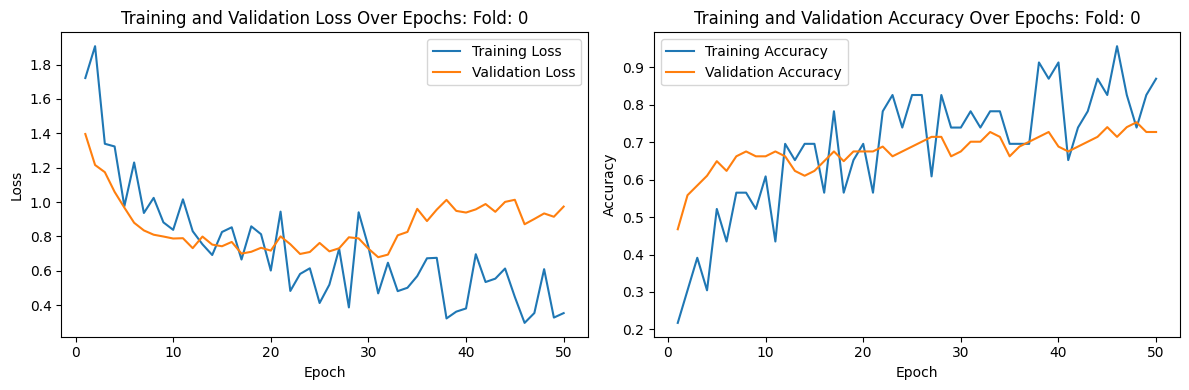

Starting Training Fold: 1


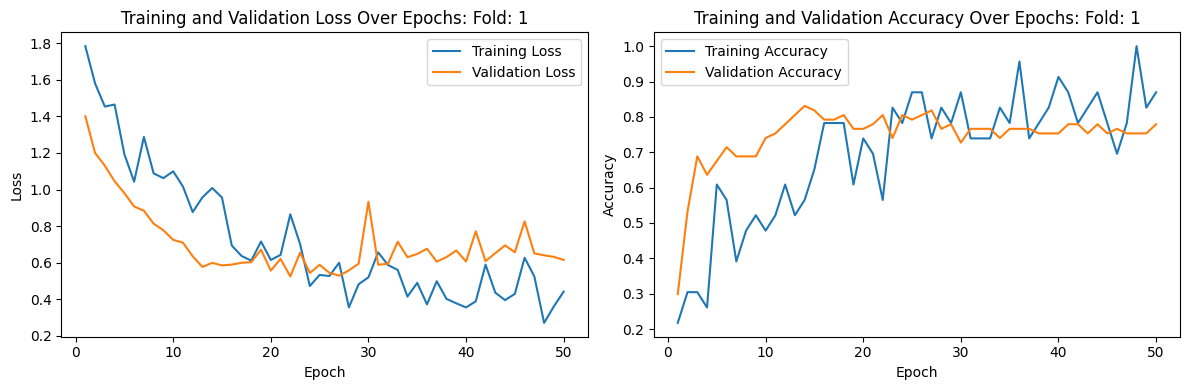

Starting Training Fold: 2


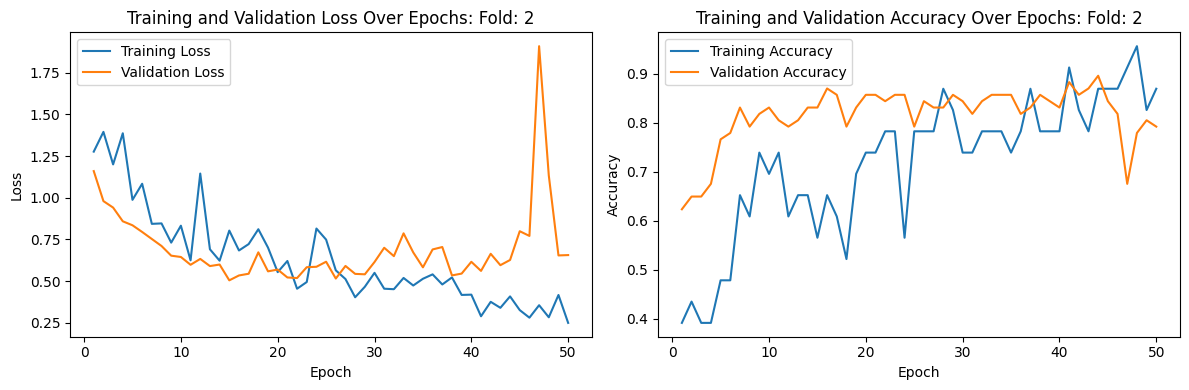

Starting Training Fold: 3


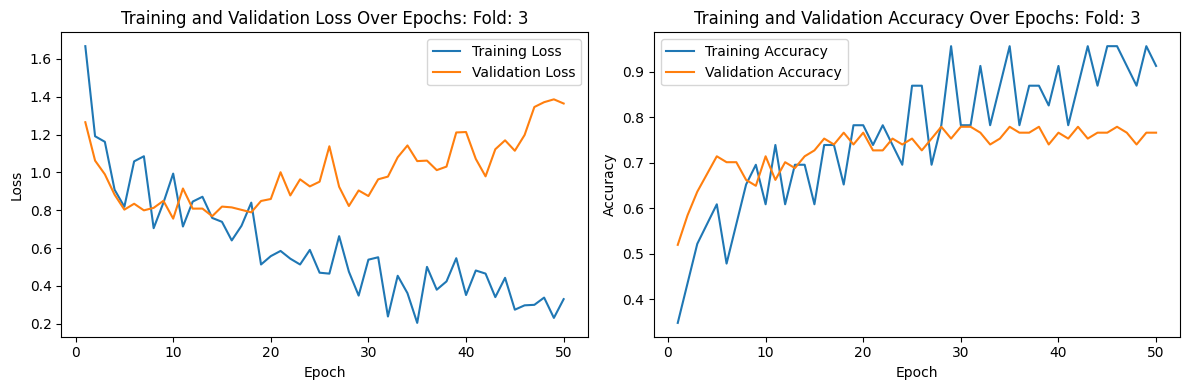

Starting Training Fold: 4


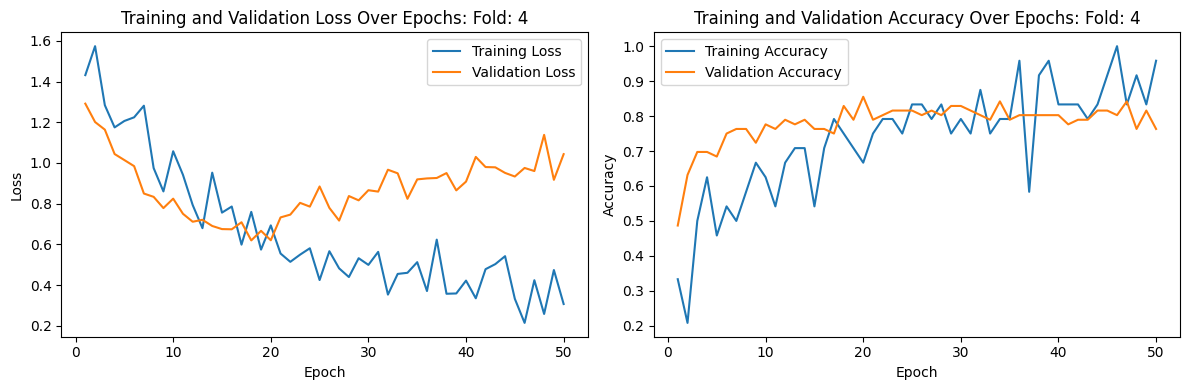

Starting Training Fold: 5


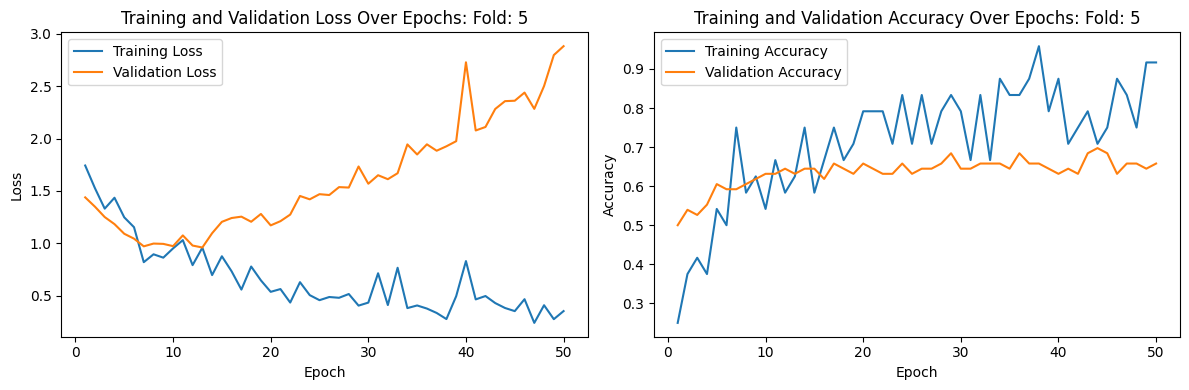

Starting Training Fold: 6


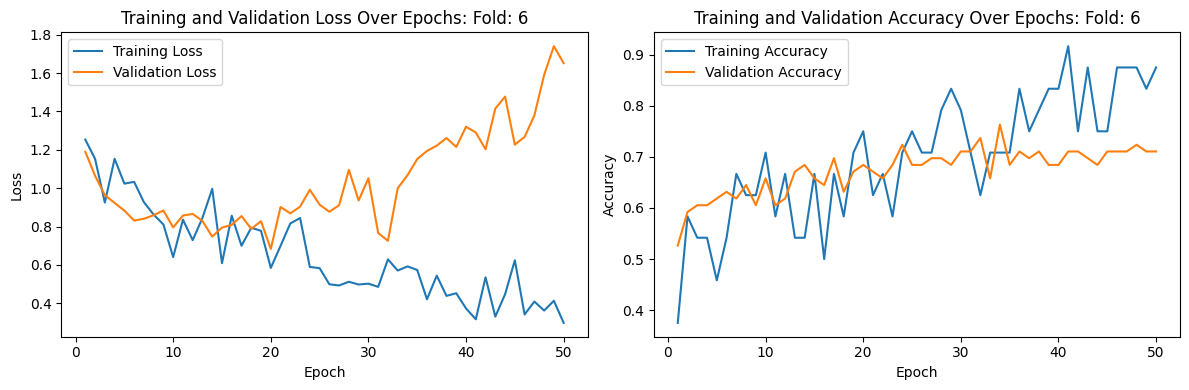

Starting Training Fold: 7


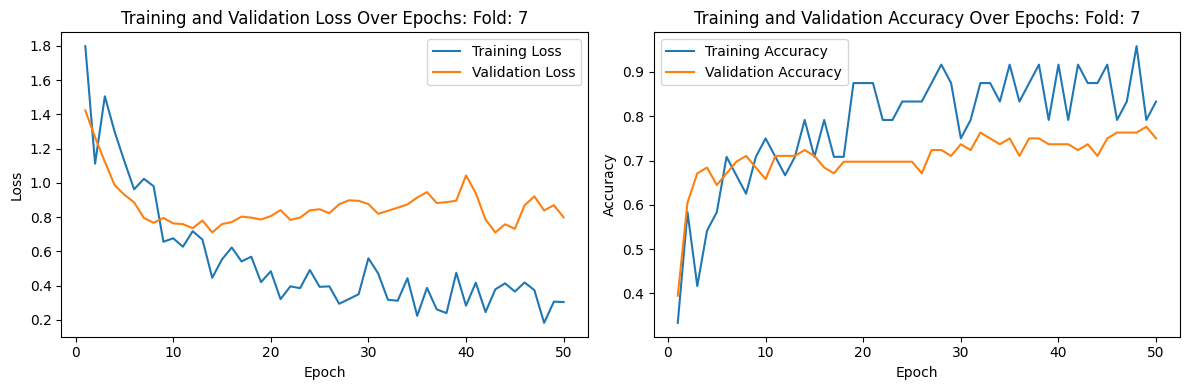

In [80]:
for i, (train_index, val_index) in enumerate(kf.split(mrna_train)):
    mrna_X_train, mrna_X_val = mrna_train[train_index], mrna_train[val_index]
    mrna_y_train, mrna_y_val = mrna_y[train_index], mrna_y[val_index]
    methy_X_train, methy_X_val = methy_train[train_index], methy_train[val_index]
    methy_y_train, methy_y_val = methy_y[train_index], methy_y[val_index]
    mirna_X_train, mirna_X_val = mirna_train[train_index], mirna_train[val_index]
    mirna_y_train, mirna_y_val = mirna_y[train_index], mirna_y[val_index]
    print(f"Starting Training Fold: {i}")
    
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                                                                            mirna_train = mirna_X_train,
                                                                            methy_train = methy_X_train,
                                                                            mrna_train = mrna_X_train,
                                                                            mirna_test = mirna_X_val,
                                                                            methy_test = methy_X_val,
                                                                            mrna_test = mrna_X_val,
                                                                            y_train = mrna_y_train,
                                                                            y_val = mrna_y_val,
                                                                            n_epochs=50)
    plot_model(train_losses, train_accuracies, val_losses, val_accuracies, i)